In [12]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [9]:
import sys
from pathlib import Path

# Agregar la carpeta src al Path para poder cargar los métodos y clases necesarias.
# También agregamos la carpeta data.
src_path = str(Path.cwd().parents[1] / "src")

if src_path not in sys.path:
    sys.path.append(src_path) 

# Lens Classifiers Replication

Este notebook fue utilizado para replicar las CNN ganadoras de ambas categorías del Bologna Lens Finding Challenge. Esto fue realizado con el objetivo de encontrar posibles arquitecturas a utilizar en la GAN, como también para ser utilizadas en la evaluación de los resultados.

- Space Based
~~~
Schaefer, C., Geiger, M., Kuntzer, T., y Kneib, J.-P. (2018). Deepconvolutional neural networks as strong gravitational lens detectors.Astronomy &Astrophysics, 611:A2.
~~~
- Ground Based
~~~
Lanusse, F., Ma, Q., Li, N., Collett, T. E., Li, C.-L., Ravanbakhsh,S., Mandelbaum, R., y Póczos, B. (2017). Cmu deeplens: deep learning for automatic image-based galaxy–galaxy strong lens finding.Monthly Notices of the RoyalAstronomical Society, 473(3):3895–3906.
~~~

## Cargar Librerías

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from keras.models import Model, load_model
from keras.layers import (
    Conv2D,
    BatchNormalization,
    Input,
    Activation,
    Add,
    AveragePooling2D,
    Dense,
    Flatten,
    MaxPooling2D,
    Dropout,
    GlobalAveragePooling2D
)
from keras import backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence
from keras.initializers import VarianceScaling


Using TensorFlow backend.


In [10]:
from utils.data import (
    read_ground_based_images,
    read_space_based_images,
    read_space_based_in_chunks,
    get_test_predictions
)

In [5]:
from imblearn.keras import balanced_batch_generator
from imblearn.under_sampling import NearMiss

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_curve,
    roc_auc_score,
    confusion_matrix
)

In [7]:
from skimage.transform import rotate

## CMU DeepLens (Ground Based)

Esta red es una arquitectura de tipo ResNet. Está compuesta por dos tipos de bloques residuales, uno que mantiene las dimensiones de la imagen, mientras que el otro duplica el número de canales, pero disminuyendo las dimensiones a la mitad. Este descenso dimensional se realiza utilizando convoluciones con stride 2. A continuación se presentan las arquitecturas de estos dos tipos de bloques.

<div class='container'>
    <div class='row'>
        <div class='col'>
            <img src='../../static/resnet16-32.png' style='float:left;'></img>
        </div>
        <div class='col'>
            <img src='../../static/resnet32-62-stride2.png' style='float:right;'></img>
        </div>
    </div>
</div> 

La arquitectura utilizada utiliza un stack de 15 bloques resnet, 11 que mantienen dimensiones y 4 que presentan stride 2. La primera capa de la arquitectura es una capa convolucional con filtros de 7x7, 32 featuremaps, activación ELU y Batch Normalization. Su capa de salida es fully connected con una neurona con activación sigmoid, esto previamente pasado por un average pooling.

Los bloques resnet utilizan la _**Exponential Linear Unit**_ (ELU) como función de activación, la cual se define de la siguiente manera.

$$ 
f(x)=
\begin{cases}
x,  \hspace{2cm}si \hspace{0.5cm} x > 0\\
e^{x - 1}, \hspace{1.5cm} etoc\\
\end{cases}
$$

En términos de preprocesamiento, realizan una normalización para cada banda de las imágenes. Para esto restan la media de las imágenes desde el set de entrenamiento, para luego normalizar por la desviación estándar del ruido de la banda. También se hace un _clipping_ considerando un rango definido por $k\sigma$, donde $k$ generalmente tenía el valor de 250. En caso de tener pixeles enmascarados se deja con un valor de 0.

Se realiza _data augmentation_, definido por las siguientes operaciones.
- Rotaciones en aleatorias en un rango $[-90,90]$.
- Flips horizontales y verticales aleatorios.
- Zooming aleatorios en un rango $[0.9,1]$.

Para el entrenamiento consideran una inicialización de pesos aleatorios, obtenidos desde una distribución normal, utilizan 120 epoch con un minibatch de 128. Adam para el optimizador, con una tasa de aprendizaje de $0.001$, la cual se divide por 10 cada 40 epochs.

### Implementación

#### Cargar datos

In [8]:
df = pd.read_csv(
    '../../data/ground_based_data/GroundBasedTraining/classifications.csv',
    sep=','
)
df = df.astype({'ID':int})

try:
    dict_data = np.load('../../data/ground_based_image_data.npz')
    # extract the first array
    x_train = dict_data['arr_0']
except:
    path_ground_based = '../../data/ground_based_data/GroundBasedTraining/Public/'
    x_train = read_ground_based_images(
        path_ground_based,
        df
    )
    np.savez_compressed('../../data/ground_based_image_data.npz', x_train)


#### Arquitectura

In [9]:
def resnet_block(previus_layer,filters):
    block = BatchNormalization()(previus_layer)
    block = Activation('elu')(block)
    block = Conv2D(int(filters/2),(1,1),padding='same',kernel_initializer='he_normal')(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Conv2D(int(filters/2),(3,3),padding='same',kernel_initializer='he_normal')(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Conv2D(filters,(1,1),padding='same',kernel_initializer='he_normal')(block)
    output = Add()([previus_layer,block]) #join paths
    return output

In [10]:
def strided_resnet_block(previus_layer,input_filters,output_filters):
    batch_norm = BatchNormalization()(previus_layer)
    elu_activation = Activation('elu')(batch_norm)
    #skip connection
    skip_conv = Conv2D(output_filters,(1,1),strides=2,padding='same',kernel_initializer='he_normal')(elu_activation)
    #Connected path
    block = Conv2D(input_filters,(1,1),strides=2,padding='same',kernel_initializer='he_normal')(elu_activation)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Conv2D(input_filters,(3,3),padding='same',kernel_initializer='he_normal')(block)
    block = BatchNormalization()(block)
    block = Activation('elu')(block)
    block = Conv2D(output_filters,(1,1),padding='same',kernel_initializer='he_normal')(block)
    #join paths
    output = Add()([skip_conv,block])
    return output

In [11]:
def build_deeplens_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    #first convolutional blocks
    initial_conv = Conv2D(32,(7,7),padding='same')(input_layer)
    initial_conv = Activation('elu')(initial_conv)
    initial_conv = BatchNormalization()(initial_conv)
    #stack of resnet blocks
    resnet = resnet_block(initial_conv,32)
    resnet = resnet_block(resnet,32)
    resnet = resnet_block(resnet,32)
    resnet = strided_resnet_block(resnet,32,64)
    resnet = resnet_block(resnet,64)
    resnet = resnet_block(resnet,64)
    resnet = strided_resnet_block(resnet,64,128)
    resnet = resnet_block(resnet,128)
    resnet = resnet_block(resnet,128)
    resnet = strided_resnet_block(resnet,128,256)
    resnet = resnet_block(resnet,256)
    resnet = resnet_block(resnet,256)
    resnet = strided_resnet_block(resnet,256,512)
    resnet = resnet_block(resnet,512)
    resnet = resnet_block(resnet,512)
    
    avg_pool = GlobalAveragePooling2D()(resnet)
    dense = Dense(1,activation='sigmoid', kernel_initializer='he_normal')(avg_pool)
    model = Model(input_layer,dense)
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy'])
    return model
    

In [12]:
model = build_deeplens_classifier((101,101,4))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 32) 6304        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 32) 128         activation_1[0][0]               
____________________________________________________________________________________________

#### Preprocesamiento

In [13]:
y = df['is_lens'].values
x_train, x_val, y_train, y_val = train_test_split(x_train,y,test_size=0.2,random_state=42,stratify=y)

In [14]:
print("x_train shape: {}".format(x_train.shape))
print("x_val shape: {}".format(x_val.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_train shape: {}".format(y_val.shape))

x_train shape: (16000, 101, 101, 4)
x_val shape: (4000, 101, 101, 4)
y_train shape: (16000,)
y_train shape: (4000,)


Para esta fase se utilizará el mismo pre-procesamiento utilizado en el [notebook](https://github.com/McWilliamsCenter/CMUDeepLens/blob/master/notebooks/BLF_GroundBased.ipynb) publicado por los autores. Leí el paper y es el mismo procedimiento, salvo que ingresan el $\sigma$ a mano, colocandole un valor de 100.

Por problemas momentaneos de ram voy a cambiar la manera de escalar.

In [ ]:
#vmin=-1e-9
#vmax=1e-9
#scale=100

mask = (x_train == 100)
mask_val = (x_val == 100)

x_train[mask] = 0
x_val[mask_val] = 0

# Simple clipping and rescaling the images

#x_train = np.clip(x_train, vmin, vmax)/vmax * scale
#x_val = np.clip(x_val, vmin, vmax)/vmax * scale 
TRAIN_MEAN = x_train.mean()
TRAIN_STD = x_train.std()

x_train = (x_train - TRAIN_MEAN)/TRAIN_STD
x_val = (x_val - TRAIN_MEAN)/TRAIN_STD

x_train[mask] = 0
x_val[mask_val] = 0

#### Entrenamiento

No logré entrenar esta arquitectura, principalmente porque no tengo suficiente memoria en mi GPU (Nvidia GTX 1050). En algún momento me gustaría entrenarla para ver si logré replicarla correctamente.

In [ ]:
def lr_scheduler(epoch, lr=0.001):
    if epoch%40 == 0:
        return lr / 10
    else:
        return lr

In [ ]:
#Data Augmentation
datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 90,
    zoom_range = [0.9,1]
)

In [ ]:
train_history = model.fit_generator(
        datagen.flow(
            x_train,
            y_train,
            batch_size=32
        ),
        steps_per_epoch=len(x_train) / 32,
        epochs=120,
        validation_data=(x_val, y_val),
        callbacks=[
            LearningRateScheduler(lr_scheduler),
            ModelCheckpoint(
                './models/CMU/cmu_{val_loss:.2f}.hdf5',
                monitor='val_loss',
                save_best_only=True)
        ]
    )

#### Evaluación

## LensFinder (Space Based)

En este paper pruebas varios tipos de arquitectura, pero la que utilizan para el challenge es la más simple de todas ellas. Está compuesta por bloques convolucionales que tienen dos capas convolucionales, seguidas de capas de max pooling y de batch normalization. A diferencia de las arquitecturas anteriores, esta arquitectura cuenta con capas densas al final, utilizando también capas dropout.

<img src='../../static/lensfinder_baseline.png' style='float:center;'></img>

### Implementación

#### Cargar datos

In [8]:
df_space = pd.read_csv(
    '../../data/space_based_data/SpaceBasedTraining/classifications.csv',
    sep=','
)
df_space = df_space.astype({'ID':int})

try:
    dict_data = np.load('../../data/space_based_image_data.npz')
    # extract the first array
    space_based_lens_images = dict_data['arr_0']
except:
    path_space_based = '../../data/space_based_data/SpaceBasedTraining/Public/Band1/'
    space_based_lens_images = read_space_based_images(
        path_space_based,
        df_space
    )
    np.savez_compressed('../../data/space_based_image_data.npz', space_based_lens_images)

#### Arquitectura

In [10]:
def custom_relu(x):
    relu = K.relu(x)
    return (relu - 0.3989422804014327) * 1.712858550449663


In [11]:
def build_conv_block(previus_layer,filters,first_block=False):
    if first_block:
        block = Conv2D(filters,(4,4),activation=custom_relu,kernel_initializer=VarianceScaling())(previus_layer)
    else:
        block = Conv2D(filters,(3,3),activation=custom_relu,kernel_initializer=VarianceScaling())(previus_layer)
    block = Conv2D(filters,(3,3),activation=custom_relu,kernel_initializer=VarianceScaling())(block)
    block = MaxPooling2D()(block)
    block = BatchNormalization()(block)
    return block

In [12]:
def build_lensfinder_classifier(input_shape):
    input_layer = Input(shape=input_shape)
    lensfinder = build_conv_block(input_layer,16,first_block=True)
    lensfinder = build_conv_block(lensfinder,32)
    lensfinder = build_conv_block(lensfinder,64)
    lensfinder = Dropout(0.5)(lensfinder)
    lensfinder = Conv2D(128,(3,3),activation=custom_relu,kernel_initializer=VarianceScaling())(lensfinder)
    lensfinder = Dropout(0.5)(lensfinder)
    lensfinder = Conv2D(128,(3,3),activation=custom_relu,kernel_initializer=VarianceScaling())(lensfinder)
    lensfinder = BatchNormalization()(lensfinder)
    lensfinder = Dropout(0.5)(lensfinder)
    lensfinder = Flatten()(lensfinder)
    lensfinder = Dense(1024,activation=custom_relu,kernel_initializer=VarianceScaling())(lensfinder)
    lensfinder = Dropout(0.5)(lensfinder)
    lensfinder = Dense(1024,activation=custom_relu,kernel_initializer=VarianceScaling())(lensfinder)
    lensfinder = Dropout(0.5)(lensfinder)
    lensfinder = Dense(1024,activation=custom_relu,kernel_initializer=VarianceScaling())(lensfinder)
    lensfinder = BatchNormalization()(lensfinder)
    lensfinder = Dense(1,activation='sigmoid',kernel_initializer=VarianceScaling())(lensfinder)
    #idk if its sigmoid activation, the paper didnt show it
    model = Model(input_layer,lensfinder)
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer='adam')
    return model

In [32]:
lensfinder = build_lensfinder_classifier((101,101,1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 101, 101, 1)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 98, 98, 16)        272       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 96, 96, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 46, 46, 32)        4640      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 44, 44, 32)        9248      
__________

#### Preprocesamiento

Si bien, en el paper no mencionan el preprocesamiento que se utiliza para las imágenes. Sin embargo, gracias al paper del challenge logré dar con el [github](https://github.com/mariogeiger/lensfinder-euclid/blob/master/arch_baseline.py) con la implementación de esta red, por lo que realizaré dicho preprocesamiento.

Básicamente consisten en un Standard Scaler, considerando todos los datos del set de entrenamiento.

In [9]:
SPACE_TRAIN_MEAN = space_based_lens_images.mean()
SPACE_TRAIN_STD = space_based_lens_images.std()

In [12]:
print(SPACE_TRAIN_MEAN)

4.3368545e-13


In [13]:
print(SPACE_TRAIN_STD)

5.5039e-12


In [14]:
space_based_lens_images[space_based_lens_images == 100] = 0.0
space_based_lens_images = (space_based_lens_images - SPACE_TRAIN_MEAN) / SPACE_TRAIN_STD

Ahora separamos en conjunto de entrenamiento y validación. Ellos toman como validación las últimas 3000 imágenes del set de entrenamiento. Yo tomaré 3000 también, pero mediante muestreo estratificado.

In [15]:
y = df_space['is_lens'].values
x_train, x_val, y_train, y_val = train_test_split(
    space_based_lens_images,
    y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

print("x_train shape: {}".format(x_train.shape))
print("x_val shape: {}".format(x_val.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_train shape: {}".format(y_val.shape))

x_train shape: (17000, 101, 101, 1)
x_val shape: (3000, 101, 101, 1)
y_train shape: (17000,)
y_train shape: (3000,)


#### Entrenamiento

Para el entrenamiento utilizan batch balanceados de 30 imágenes. También, aplican data augmentation, considerando rotaciones en 90 grados y flips, y también hacen shift y multiplicación por escalar. Estas dos últimas transformaciones no las mencionan en su paper, pero están en el paper del challenge y en su implementación en github.

Como Keras no tiene implementado algún método para rotar por angulos específicos, por lo que aplicaré estas transformaciones por fuera de keras.

In [16]:
def shift_and_multiply(image):
    mul = np.random.uniform(0.8, 1.2)
    shift = np.random.uniform(-0.1, 0.1)
    return image * mul + shift

In [17]:
data_aug_gen = ImageDataGenerator(
    horizontal_flip = True,
    preprocessing_function = shift_and_multiply
)

In [18]:
def apply_rotations(batch_x,batch_labels):
    augmented_batch = list()
    augmented_labels = list()
    rotation_angles = [90,180,270]
    for x, y in zip(batch_x,batch_labels):
        augmented_batch.append(x)
        augmented_labels.append(y)
        for angle in rotation_angles:
            augmented_batch.append(rotate(x,angle))
            augmented_labels.append(y)
    augmented_batch = np.asarray(augmented_batch)
    augmented_labels = np.asarray(augmented_labels)
    return augmented_batch, augmented_labels
        

La siguiente clase se encarga de aplicar un generador que entrega un batch balanceado, para luego aplicar las operaciones de data augmentation sobre dicho batch.

In [19]:
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, data_aug_gen, batch_size=30):
        self.data_aug_gen = data_aug_gen
        self.batch_size = batch_size
        self._shape = x.shape        
        data_aug_gen.fit(x)
        self.batch_gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1),
            y,
            batch_size=self.batch_size
        )

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.batch_gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        x_batch, y_batch = apply_rotations(x_batch,y_batch)
        return self.data_aug_gen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [20]:
balanced_generator = BalancedDataGenerator(x_train, y_train, data_aug_gen, batch_size=30)
steps_per_epoch = balanced_generator.steps_per_epoch

In [34]:
train_history = lensfinder.fit_generator(
        balanced_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=200,
        validation_data=(x_val, y_val),
        callbacks=[ModelCheckpoint(
            '../../models/lensfinder/lensfinder_model_val_loss_{val_loss:.2f}.hdf5',
            monitor='val_loss',
            save_best_only=True
        )]
    )

Epoch 1/200
341/341 [==============================] - 292s 856ms/step - loss: 0.6793 - val_loss: 0.5940
Epoch 2/200
341/341 [==============================] - 244s 714ms/step - loss: 0.5984 - val_loss: 0.7024
Epoch 3/200
341/341 [==============================] - 235s 690ms/step - loss: 0.5323 - val_loss: 0.6889
Epoch 4/200
341/341 [==============================] - 243s 712ms/step - loss: 0.4775 - val_loss: 0.4873
Epoch 5/200
341/341 [==============================] - 231s 678ms/step - loss: 0.4731 - val_loss: 0.3865
Epoch 6/200
341/341 [==============================] - 234s 686ms/step - loss: 0.4378 - val_loss: 0.5084
Epoch 7/200
341/341 [==============================] - 236s 692ms/step - loss: 0.4119 - val_loss: 0.5498
Epoch 8/200
341/341 [==============================] - 237s 694ms/step - loss: 0.4163 - val_loss: 0.3840
Epoch 9/200
341/341 [==============================] - 255s 749ms/step - loss: 0.4396 - val_loss: 0.5997
Epoch 10/200
341/341 [==============================] -

Epoch 155/200
341/341 [==============================] - 108s 317ms/step - loss: 0.2210 - val_loss: 0.2874
Epoch 156/200
341/341 [==============================] - 108s 318ms/step - loss: 0.3847 - val_loss: 0.4161
Epoch 157/200
341/341 [==============================] - 108s 318ms/step - loss: 0.3352 - val_loss: 0.3850
Epoch 158/200
341/341 [==============================] - 109s 318ms/step - loss: 0.2994 - val_loss: 0.3435
Epoch 159/200
341/341 [==============================] - 109s 318ms/step - loss: 0.2874 - val_loss: 0.3190
Epoch 160/200
341/341 [==============================] - 109s 320ms/step - loss: 0.2691 - val_loss: 0.3243
Epoch 161/200
341/341 [==============================] - 109s 319ms/step - loss: 0.2637 - val_loss: 0.3164
Epoch 162/200
341/341 [==============================] - 108s 318ms/step - loss: 0.2492 - val_loss: 0.3422
Epoch 163/200
341/341 [==============================] - 109s 319ms/step - loss: 0.2391 - val_loss: 0.3338
Epoch 164/200
341/341 [==============

In [21]:
def plot_loss(model_history):
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = [x for x in range(len(train_loss))]
    plt.figure(figsize=(15,7))
    plt.plot(epochs,train_loss,'.-')
    plt.plot(epochs,val_loss,'.-')
    plt.legend(['Training','Validation'])
    plt.title('Loss versus epoch first training')
    plt.xlabel('Epoch')
    plt.ylabel('Binary crossentropy')
    
    #annotate min value
    min_index = np.argmin(model_history.history['val_loss'])
    min_value = model_history.history['val_loss'][min_index].round(4)
    plt.annotate(
        'Validation Min = {}'.format(min_value),
        xy=(min_index+1, min_value),
        xycoords='data',
        xytext=(50, 100),
        textcoords='offset points',
        fontsize=14,
        arrowprops=dict(arrowstyle="->")
    )
    plt.show()

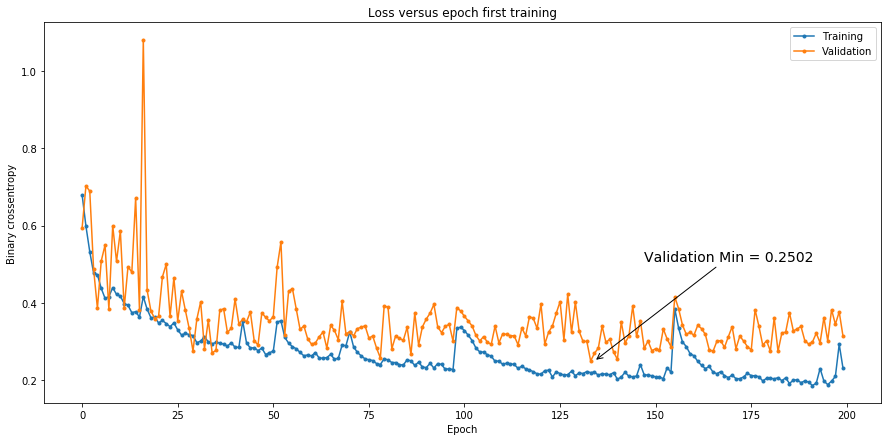

In [77]:
plot_loss(train_history)

#### Evaluación

Para la evaluación, se utilizarán las mismas métricas utilizadas en el paper original, pero además se utilizará el _classification report_ de _sklearn_, para así obtener métricas de precision, recall, accuracy y f1-score. Esto se realizará para los conjuntos de validación y de pruebas. El conjunto de pruebas está compuesto por 100000 imágenes, por lo que espero que mi ram las aguante. En caso contrario se procesarán por batches.

Finalmente se compararán con los resultados presentados por el paper, para así evaluar que tan bien logré replicar la red en este primer intento.

In [22]:
df_space_test = pd.read_csv(
    '../../data/space_based_data/euclidB_image_catalog.csv',
    sep=','
)
df_space_test = df_space_test.astype({'ID':int})
df_space_test.sort_values(by='ID',inplace=True)
df_space_test.head()

,ID,x_crit,y_crit,ID_source,z_source,EUC_VIS_mag_source,caustic_plane,caustic_index,z_caustic_plane,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma,num_lensed_images,magnification_eff,KiDS_noise_map,total_numb_pixels_sigma,flux_in_sigma,num_images,EUC_VIS_mag_lens,kids_lens_image,mobs_lens_imag,no_source
29386,100000,0.008547,0.002478,6499,1.72,25.947,8,33564,1.5,7.964440e-12,60,84.4225,1,1.95109,0,2147,13858.10,708,24.0633,0,1,0
35734,100001,-0.001746,0.006276,5136,2.80,25.969,8,46141,1.5,2.703240e-11,291,865.9030,2,6.83700,0,1869,3226.74,738,23.4306,0,1,0
23240,100002,0.001347,-0.001814,7025,3.40,26.128,8,21973,1.5,6.880030e-11,0,0.0000,0,0.00000,0,1930,3213.82,711,23.9269,0,1,1
4074,100003,-0.008623,0.002193,5946,2.48,23.620,8,27085,1.5,3.528220e-12,1002,2638.6300,1,3.22487,0,1706,3307.80,797,23.2667,0,1,0
47413,100004,0.000066,0.004247,3034,2.82,25.409,8,39754,1.5,4.721590e-12,0,0.0000,0,0.00000,0,2006,3994.27,725,23.6027,0,1,1


#### Load model

In [23]:
model = load_model(
    '../../models/lensfinder/lensfinder_model_val_loss_0.25.hdf5',
    custom_objects={'custom_relu': custom_relu})

#### Get predictions

In [24]:
path_space_based_test = '../../data/space_based_data/SpaceBasedTesting/Public/Band1/'
y, y_pred, y_pred_classes = get_test_predictions(
    path_space_based_test,
    df_space_test,
    model,
    SPACE_TRAIN_MEAN,SPACE_TRAIN_STD
)

Tiempo de ejecución: 2672.2058341503143 segundos


#### Classification report Lensfinder

In [31]:
print(classification_report(y,y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     60025
           1       0.84      0.82      0.83     39975

    accuracy                           0.87    100000
   macro avg       0.86      0.86      0.86    100000
weighted avg       0.87      0.87      0.87    100000



#### ROC y AUROC

In [34]:
false_positive_rate,true_positive_rate,tresholds = roc_curve(y, y_pred)

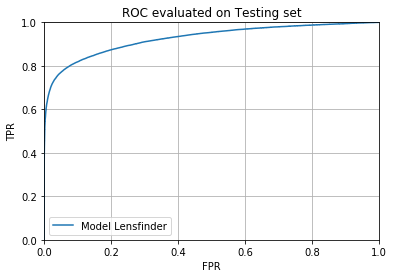

In [38]:
plt.plot(false_positive_rate,true_positive_rate,label='Model Lensfinder')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC evaluated on Testing set')
plt.grid('on')

In [60]:
print("Área under ROC curve: {}".format(roc_auc_score(y,y_pred).round(4)))

Área under ROC curve: 0.9262


El área bajo la curva ROC reportada utilizando un committee de 5 clasificadores fue de 0.9326, por lo cual esta reproducción se encuentra "cerca", con un 0.9262.

#### Confusion Matrix

In [57]:
def plot_confusion_matrix(y,y_pred_classes):
    cm = confusion_matrix(y, y_pred_classes)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt='d'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.yaxis.set_ticklabels(['No Lens', 'Lens'])
    ax.xaxis.set_ticklabels(['No Lens', 'Lens'])
    plt.show()

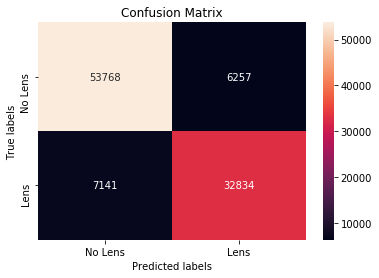

In [58]:
plot_confusion_matrix(y,y_pred_classes)

En la matriz de confusión que se reporta en el paper original, se tiene mucho menos falsos positivos (6257 vs 40), pero también se menciona que se utiliza un threshold para su construcción cuyo valor no se especifica, por lo que no puedo hacer muchas comparaciones entre ellas.